In [1]:
from dask_jobqueue import SLURMCluster
import matplotlib.pyplot as plt 
import glob
import os
import xarray as xr 
import pandas as pd
import numpy as np


from dask_jobqueue import SLURMCluster

cluster = SLURMCluster(
    job_name="Climt1",          # --job-name
    cores=12,                     # Number of cores per task (adjust if needed)
    processes=6,                 # One process per task
    memory="100GB",               # --mem
    walltime="01:15:00",         # --time
    queue="med",               # --partition
    log_directory=".",           # Logs will be saved to the current directory
)


from dask.distributed import Client


cluster.scale(jobs=10)
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: http://10.42.239.61:8787/status,
Dashboard: http://10.42.239.61:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.42.239.61:45725,Workers: 0
Dashboard: http://10.42.239.61:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [2]:
import pandas as pd 
import xarray as xr 

start_date = '2011-10-01'
end_date = '2012-03-31'

In [4]:
inter_data = '/home1/nalex2023/Datasets/interpsonde_manus'


dset_inter = xr.open_mfdataset(f'{inter_data}/*.nc', combine='by_coords')


In [5]:
imerg_data = '/home1/nalex2023/Datasets/IMERG'

imerg_2011 = xr.open_dataset(f'{imerg_data}/imerg_2011_maritime.nc',chunks='auto').sel(time=slice(start_date,end_date))

imerg_2012 = xr.open_dataset(f'{imerg_data}/imerg_2012_maritime.nc',chunks='auto').sel(time=slice(start_date,end_date))


imerg_amie = xr.concat([imerg_2011,imerg_2012],dim='time').sel(lat=slice(-5,0),lon=slice(141,154)).transpose('time','lat','lon')

In [6]:
era_data = glob.glob('/home1/nalex2023/Datasets/era5_manus/*.nc')
dft_era = pd.DataFrame(era_data, columns=['files'])


dft_era['year'] = dft_era['files'].str.split('_').str[-1].str[:4]
dft_era['month'] = dft_era['files'].str.split('_').str[-1].str[4:6].astype(int)

amie_period = pd.date_range(start='2011-10-01', end='2012-03-31', freq='D')

dft_era_amie = dft_era[(dft_era['year'].isin(amie_period.year.astype(str))) & (dft_era['month'].isin(amie_period.month))]


era_dset_amie = xr.open_mfdataset(dft_era_amie['files'].values, combine='by_coords').sel(pressure_level=slice(1000,800),latitude=slice(-1,-3),longitude=slice(146,148))


In [7]:
inter_amie = dset_inter.sel(time=slice(start_date,end_date))




In [8]:
import metpy.calc as mpcalc

imerg_diurnal = imerg_amie.groupby('time.hour').mean('time').compute().roll(hour=10)

inter_diurnal = inter_amie.groupby('time.hour').mean('time').compute().roll(hour=10)


imerg_diurnal['precip_anom'] = imerg_diurnal['precipitation'] - imerg_diurnal['precipitation'].mean('hour')

#imerg_diurnal['precip_anom'] = imerg_diurnal['precipitation'] - imerg_diurnal['precipitation'].mean('hour')

#era_dset_amie['u_anom'] = era_dset_amie['u'] - era_dset_amie['u'].mean('valid_time')
#era_dset_amie['v_anom'] = era_dset_amie['v'] - era_dset_amie['v'].mean('valid_time')

era_dset_amie_diurnal = era_dset_amie.groupby('valid_time.hour').mean().sel(pressure_level=1000).compute().roll(hour=10)




In [9]:
from metpy.units import units

era_dset_amie_diurnal['u_anom'] = (era_dset_amie_diurnal['u'] - era_dset_amie_diurnal['u'].mean('hour')) * units('m/s')
era_dset_amie_diurnal['v_anom'] = (era_dset_amie_diurnal['v'] - era_dset_amie_diurnal['v'].mean('hour')) * units('m/s')


era_dset_amie_diurnal['speed'] = mpcalc.wind_speed(era_dset_amie_diurnal.u,era_dset_amie_diurnal.v)
era_dset_amie_diurnal['direction'] = mpcalc.wind_direction(era_dset_amie_diurnal.u,era_dset_amie_diurnal.v)

era_dset_amie_diurnal['speed_anom'] = mpcalc.wind_speed(era_dset_amie_diurnal.u_anom,era_dset_amie_diurnal.v_anom)
era_dset_amie_diurnal['direction_anom'] = mpcalc.wind_direction(era_dset_amie_diurnal.u_anom,era_dset_amie_diurnal.v_anom)




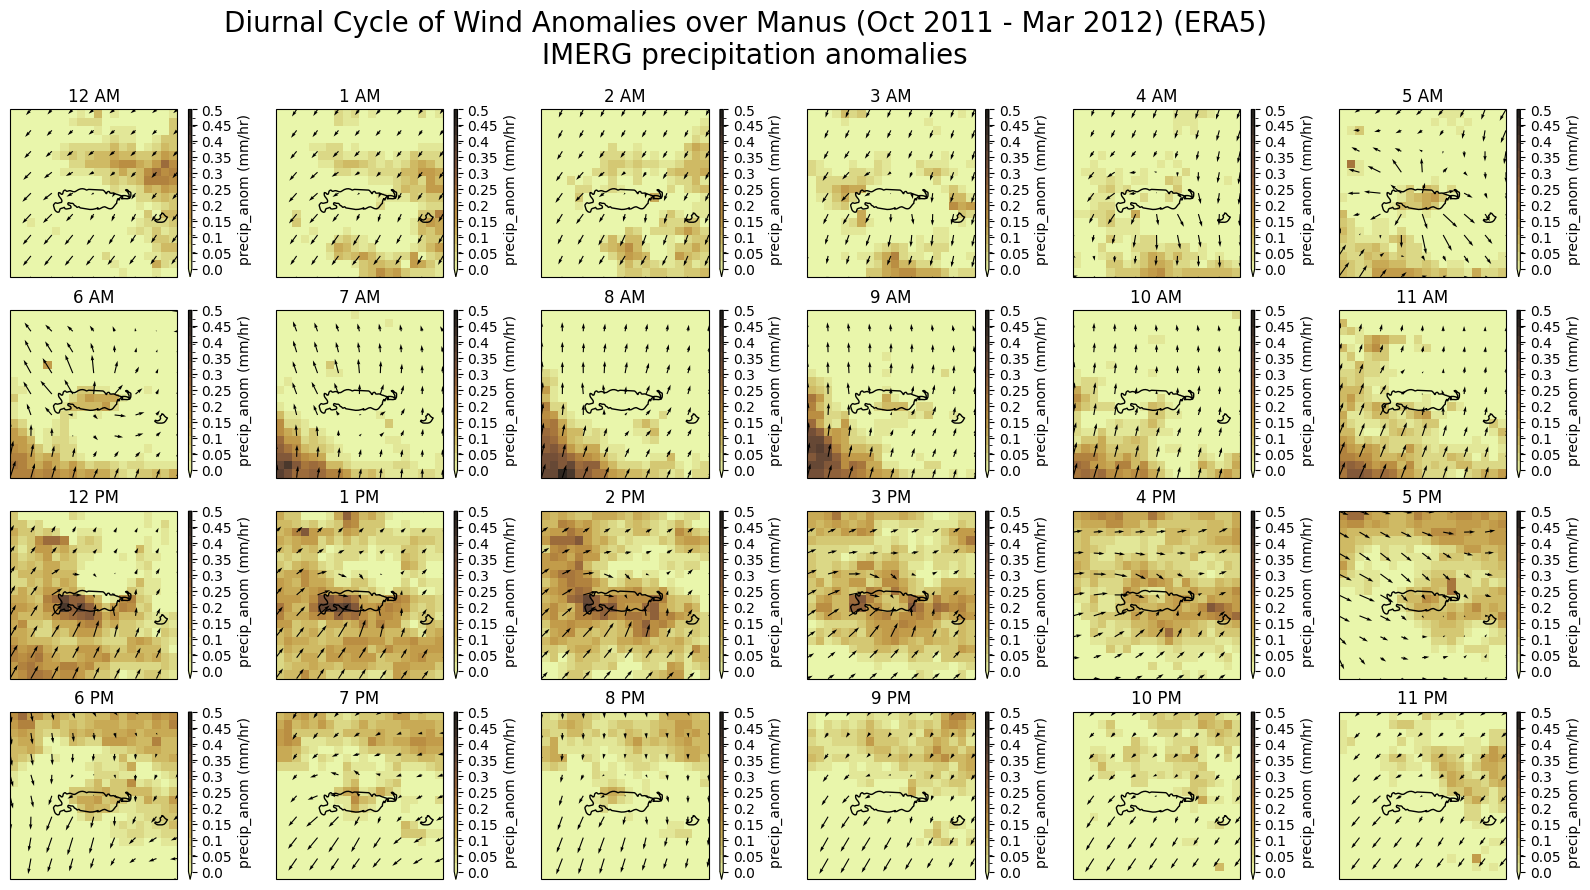

In [12]:
import cmocean
import cartopy.crs as ccrs



fig,ax = plt.subplots(4,6,figsize=(20,10),subplot_kw={'projection':ccrs.PlateCarree()})
axs = ax.flatten()
for i in range(24):
    x = era_dset_amie_diurnal.sel(hour=i).longitude
    y = era_dset_amie_diurnal.sel(hour=i).latitude
    u = era_dset_amie_diurnal.sel(hour=i)['u_anom']
    v = era_dset_amie_diurnal.sel(hour=i)['v_anom']
    spd = era_dset_amie_diurnal.sel(hour=i).speed
    im = imerg_diurnal['precip_anom'].sel(hour=i).sel(lat=slice(-3,-1),lon=slice(146,148)).plot(levels=20,cmap=cmocean.cm.turbid,ax=axs[i],transform=ccrs.PlateCarree(),
                                                                                          
                                                                                          add_colorbar=False,vmin=0,vmax=0.5)
    
    # colorbar
    cbar = plt.colorbar(im, ax=axs[i], orientation='vertical', pad=0.05, aspect=50)
    # round the values of the colorbar
    cbar.set_label('precip_anom (mm/hr)')
    cbar.set_ticks(np.linspace(0,0.5,11))
    cbar.set_ticklabels(np.round(np.linspace(0,0.5,11),2))
    axs[i].quiver(x,y,u,v,transform=ccrs.PlateCarree(),color='black')
    axs[i].set_extent([146,148,-3,-1])
    axs[i].coastlines()
    if i == 0:
        axs[i].set_title('12 AM')

    elif i < 12:
        axs[i].set_title(f'{i} AM')

    elif i == 12:
        axs[i].set_title('12 PM')

    else:
        axs[i].set_title(f'{i-12} PM')
    

    fig.suptitle("Diurnal Cycle of Wind Anomalies over Manus (Oct 2011 - Mar 2012) (ERA5) \n IMERG precipitation anomalies",fontsize=20)
    



In [13]:
#inter_amie['u_wind_ano'] = inter_amie['u_wind'] - inter_amie['u_wind'].mean('time')
#inter_amie['v_wind_ano'] = inter_amie['v_wind'] - inter_amie['v_wind'].mean('time')

diurnal_inter = inter_amie.groupby('time.hour').mean('time').compute().roll(hour=10)



(10.0, 20.0)

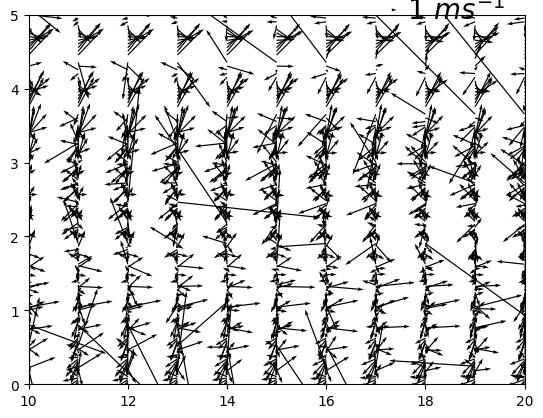

In [19]:
diurnal_inter['speed'] = mpcalc.wind_speed(diurnal_inter.u_wind,diurnal_inter.v_wind)
diurnal_inter['direction'] = mpcalc.wind_direction(diurnal_inter.u_wind,diurnal_inter.v_wind)

diurnal_inter['u_wind_ano'] = diurnal_inter['u_wind'] - diurnal_inter['u_wind'].mean('hour')
diurnal_inter['v_wind_ano'] = diurnal_inter['v_wind'] - diurnal_inter['v_wind'].mean('hour')

#diurnal_inter['speed_anom'] = mpcalc.wind_speed(diurnal_inter.u_wind_ano,diurnal_inter.v_wind_ano)

fig,ax = plt.subplots()
x = diurnal_inter.hour
y = diurnal_inter.height
u = diurnal_inter['u_wind_ano']
v = diurnal_inter['v_wind_ano']
X,Y = np.meshgrid(x,y)
#diurnal_inter['speed_anom'].plot.contourf(levels=20,cmap='RdBu_r',x='hour',y='height',ax=ax,vmin=-2,vmax=2)
qq = ax.quiver(X,Y,u,v,cmap='jet',scale=10)
qk = ax.quiverkey(qq, 0.7, .89, U=(1/10)*1,label=r'1 $ms^{-1}$', labelpos='E',
                   coordinates='figure',fontproperties={'size': 20})


ax.set_ylim(0,5)
ax.set_xlim(10,20)



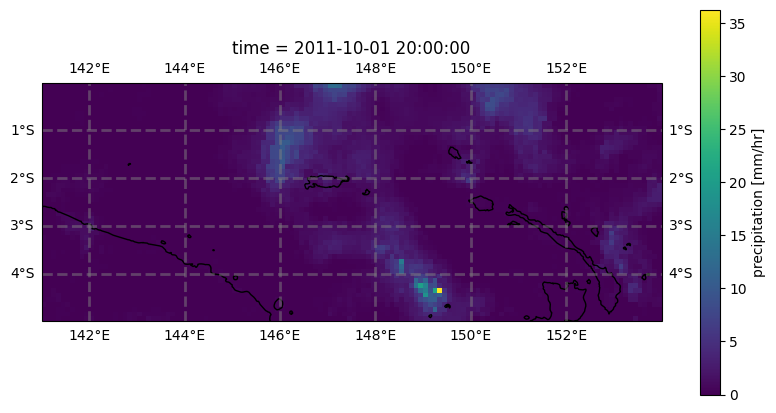

In [104]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

fig,ax = plt.subplots(1,1,figsize=(10,5),subplot_kw={'projection':ccrs.PlateCarree()})

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

imerg_amie.isel(time=20).precipitation.plot(ax=ax,transform=ccrs.PlateCarree())

ax.coastlines() 

